In [1]:
import pandas as pd

## import data

In [2]:
hrst_st_rsex=pd.read_csv('data/hrst_st_rsex_page_linear.csv')

In [3]:
lfsa_ewhais=pd.read_csv('data/lfsa_ewhais_page_linear.csv')

In [4]:
prc_ppp_ind=pd.read_csv('data/prc_ppp_ind_page_linear.csv')

In [5]:
sbs_ovw_act=pd.read_csv('data/sbs_ovw_act_page_linear.csv')

## process data

In [7]:
pd.DataFrame(hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['F']/hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['T'])

,0
geo,
AT,0.500863
BA,0.510067
BE,0.526191
BG,0.582070
CH,0.493922
CY,0.529859
CZ,0.492497
DE,0.519083
DK,0.502393


In [8]:
def process_csv(df):
    return (df.set_index('geo')[['OBS_VALUE']])

In [10]:
merged_stats=(lfsa_ewhais
 .pipe(process_csv)
 .merge(prc_ppp_ind
        .pipe(process_csv),
        left_index=True, 
        right_index=True,
        suffixes=('_lfsa_ewhais', '_prc_ppp_ind')
       )
 .merge(sbs_ovw_act
        .pipe(process_csv),
        left_index=True, 
        right_index=True,
        suffixes=('', '_sbs_ovw_act')
       )
  .merge(pd.DataFrame(hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['F']/hrst_st_rsex.pivot(index='geo',columns='sex',values='OBS_VALUE')['T']),
        left_index=True, 
        right_index=True
        )
              .reset_index()
              .query('geo!="EU27_2020"')
              .set_index('geo')
             )

In [11]:
# normalized_df=(df-df.min())/(df.max()-df.min())


In [12]:
minmax_normalised_stats=(merged_stats-merged_stats.min(numeric_only=True))/(merged_stats.max(numeric_only=True)-merged_stats.min(numeric_only=True))


In [13]:
minmax_normalised_stats

,OBS_VALUE_lfsa_ewhais,OBS_VALUE_prc_ppp_ind,OBS_VALUE,0
geo,,,,
AT,0.147368,0.104843,0.084115,0.282829
BE,0.284211,0.133622,0.100104,0.425080
BG,0.715789,0.043274,0.030555,0.738915
CY,0.663158,0.004649,0.021477,0.445684
CZ,0.589474,0.083822,0.170359,0.235842
DE,0.189474,1.000000,0.549482,0.385157
DK,0.221053,0.062298,0.105421,0.291422
EE,0.442105,0.006039,0.020405,0.875468
EL,0.800000,0.080706,0.108884,0.433269


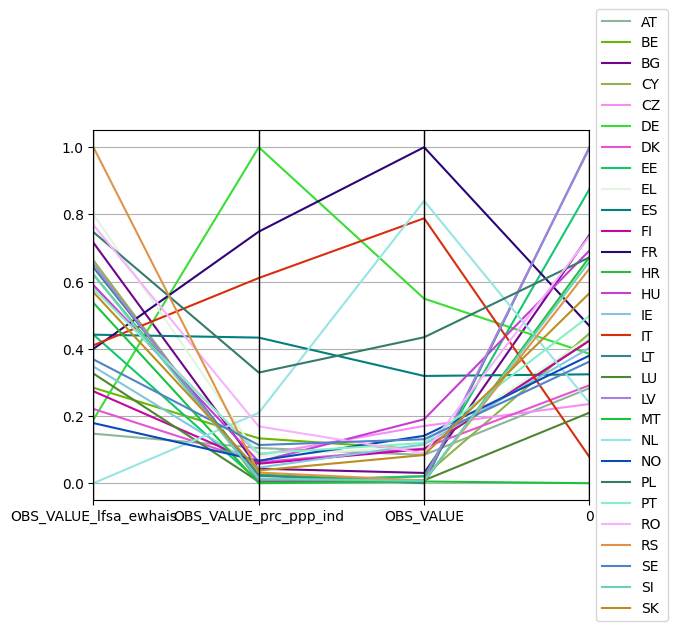

In [14]:
pd.plotting.parallel_coordinates(minmax_normalised_stats.reset_index(),'geo').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))

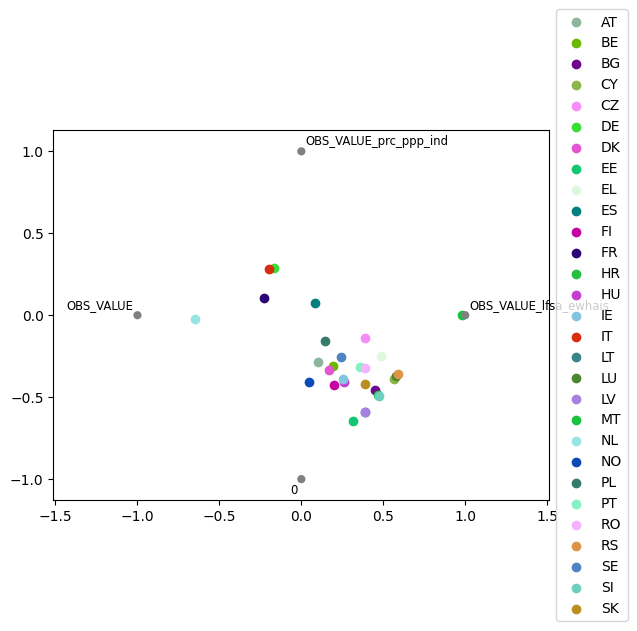

In [15]:
pd.plotting.radviz(minmax_normalised_stats.reset_index(),'geo').legend(loc='center left',bbox_to_anchor=(1.0, 0.5))
